# Network graph for linking words

In this example, we will look at using a network graph to show the linkages between words (specifically the word before the current word, current word, and the word after the current word)

In [1]:
# Load the required libraries
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt 
import re
import networkx as nx
import nxviz as nv
import html
from matplotlib.pyplot import figure, text
from sklearn.feature_extraction.text import CountVectorizer

# define text cleaning function
def clean(text):
    # convert html escapes to characters
    text = html.unescape(text)
    # tags like <tab>
    text = re.sub(r'<[^<>]*>', ' ', text)
    # markdown URLs
    text = re.sub(r'\[([^\[\]]*)\]\([^\(\)]*\)', r'\1', text)
    # text in code or brackets
    text = re.sub(r'\[[^\[\]]*\]', ' ', text)
    # standalone sequences of specials
    text = re.sub(r'(?:^|\s)[&#<>{}\[\]+|\\:-]{1,}(?:\s|$)', ' ', text)
    # standalone sequences of hyphens
    text = re.sub(r'(?:^|\s)[\-=\+]{2,}(?:\s|$)', ' ', text)
    # sequences of whitespaces
    text = re.sub(r'\s+', ' ', text)
    # fullstops and commas
    text = re.sub(r'[,.]','',text)
    return text.strip()

C:\Users\kelvi\anaconda3\lib\site-packages\nxviz\__init__.py:18: UserWarning: 
nxviz has a new API! Version 0.7.4 onwards, the old class-based API is being
deprecated in favour of a new API focused on advancing a grammar of network
graphics. If your plotting code depends on the old API, please consider
pinning nxviz at version 0.7.4, as the new API will break your old code.

To check out the new API, please head over to the docs at
https://ericmjl.github.io/nxviz/ to learn more. We hope you enjoy using it!

(This deprecation message will go away in version 1.0.)

  warnings.warn(


Set the phrase of text to use for the network graph, make a dataframe and apply the clean function to this text

In [2]:
# a whimsical phrase
text = "Apples are fruits and pears are for bears, whilst a tree grows apples it does not grow pears"

df = pd.DataFrame({'text':[text]})
 
# clean the text
df['text'] = df['text'].apply(clean)

We'll use a CountVectorizer to get each individual word and to determine how many times words occur (this can be used for adjusting the size of displayed text on the network graph)

In [3]:
for i in range(0,2,1):
    v = CountVectorizer(ngram_range=(i,i))
    x = v.fit_transform(df['text'])
    f = pd.DataFrame(x.toarray()) 
    f.columns=v.get_feature_names_out()
    f=f.sum(axis=0)
    data=pd.DataFrame(f,columns=['count']).reset_index().rename(columns={"index":"word"})

Next, we'll create a blank dataframe to use in the for loop (below) which will list which word(s) occur and where they occur

In [4]:
dfer = pd.DataFrame({'pre':['none'],'word':['none'],'post':['noner']})

for line in df['text']:
    words = line.lower().split()
    for i in data['word']: 
            if i in words[1:]:

                try:
                    pre = words[words.index(i)-1]
                except:
                    pass
                
                try:
                    post = words[words.index(i)+1]
                except:
                    pass
                    
                df1 = pd.DataFrame({'pre':[pre],'word':[i],'post':[post]})
                df2 = pd.DataFrame({'pre':[post],'word':[i],'post':[post]})
                dfer = pd.concat([dfer,df1,df2])

# join number of times keyword appears
dfer = pd.merge(dfer,data,how="left",on=['word'])
dfer = dfer[dfer['post']!='noner'] # filter out default values

Because the approach above can sometimes link the  first and last word, we will try to ensure this does not happen

In [5]:
# make sure first word and last word are not linked
def word_check(value):
    if value['pre'] == words[-1] and value['word'] == words[0]:
        return "remove"
    else:
        return "keep"
    
dfer['chk'] = dfer.apply(word_check,axis=1)

dfer = dfer[dfer['chk'] == "keep"]

We can choose to filter out any word(s) they do not fall above a specified percentage figure - to reduce the number of items displayed on the network graph

In [6]:
percenter = 0 # the percentage filter to use

dfer['pct'] = dfer['count']/sum(dfer['count'])

dfer = dfer[dfer['pct'] >= percenter]

We'll create a very basic network graph now (but can construct a more advanced graph later)

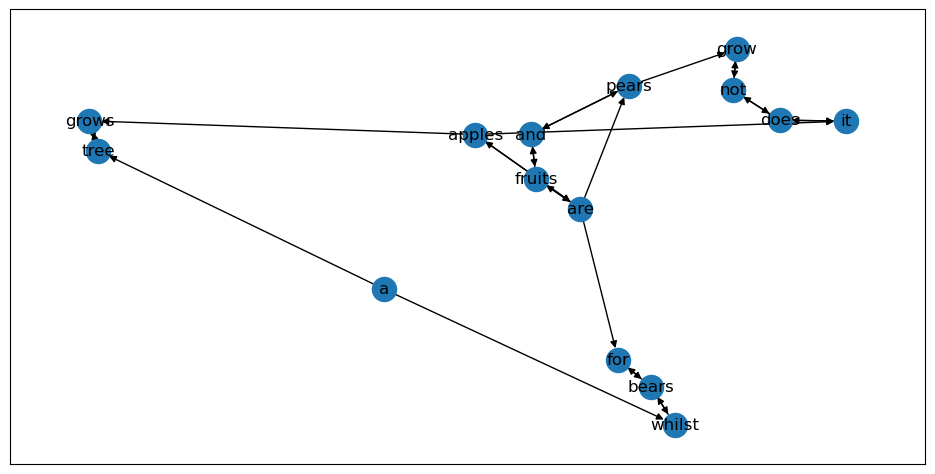

In [7]:
G = nx.from_pandas_edgelist(dfer, 
                            source='pre',
                            target='word',
                            edge_attr='count',
                            #create_using=nv.CircosPlot())
                            create_using=nx.DiGraph())

fig, ax = plt.subplots()
nx.draw_networkx(G) 
cmsize=1/2.54
fig.set_size_inches(30*cmsize, 15*cmsize)     
plt.show()

Let's create a more advanced nwtrok graph below

('a', (-0.5754349599009733, -0.16240321592928)) 1
('and', (0.5437047995012713, 0.02095231202564827)) 2.0
('apples', (-0.15565283436955585, 0.19675201803961637)) 2.0
('are', (0.04535146768333178, -0.22525658031192547)) 4.0
('bears', (-0.5978835322128887, -0.7338330974802189)) 2.0
('does', (0.621290190881776, 0.6097855466270541)) 2.0
('for', (-0.6087274258120687, -0.8902763197154462)) 2.0
('fruits', (0.3043045221292154, -0.1228107350014537)) 2.0
('grow', (0.953653427178968, 0.5149730305848325)) 2.0
('grows', (-0.8862831662681788, 0.017871457392928624)) 2.0
('it', (0.46088009769714106, 0.6368786899010552)) 2.0
('not', (0.7921882825886295, 0.5518768859507791)) 2.0
('pears', (0.7672866314652748, 0.23820390149638596)) 4.0
('tree', (-1.0, -0.04250035656563555)) 2.0
('whilst', (-0.6646775005619417, -0.6102135370143402)) 2.0


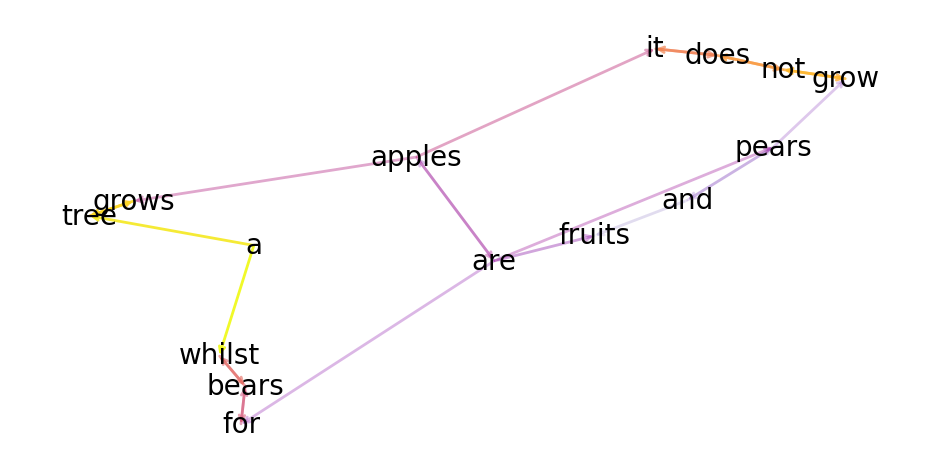

In [8]:
d = dfer.groupby("word")["count"].sum().to_dict()
for node in G.nodes:
    d.setdefault(node, 1)
    
d = dict(sorted(d.items()))
nodes, values = zip(*d.items())


seed = 13648  # Seed random number generators for reproducibility
G = G#nx.random_k_out_graph(10, 3, 0.5, seed=seed)
pos = nx.spring_layout(G, k=0.15, iterations=20)
# k controls the distance between the nodes and varies between 0 and 1
# iterations is the number of times simulated annealing is run
# default k=0.1 and iterations=50

pos = dict(sorted(pos.items()))

fig, ax = plt.subplots()

from matplotlib.pyplot import figure, text
for (node, (x, y)), noder in zip(pos.items(), values):
    print((node, (x, y)), noder )
    noder = 10 # if commented out, this will display words relative to the number of times they occur
    text(x, y, node, fontsize=noder*2, ha='center', va='center')

M = G.number_of_edges()
edge_colors = range(2, M + 2)
edge_alphas = [(1 + i) / (M + 1) for i in range(M)]
cmap = plt.cm.plasma

nodes = nx.draw_networkx_nodes(G, pos, node_size=0.000001, node_color="black")
edges = nx.draw_networkx_edges(
    G,
    pos,
    node_size=1,#[v * 100 for v in values],
    arrowstyle="->",
    arrowsize=10,
    edge_color=edge_colors,
    edge_cmap=cmap,
    width=2,
)

# set alpha value for each edge
for i in range(M):
    edges[i].set_alpha(edge_alphas[i])

pc = mpl.collections.PatchCollection(edges, cmap=cmap)
pc.set_array(edge_colors)

ax = plt.gca()
ax.set_axis_off()
cmsize=1/2.54
fig.set_size_inches(30*cmsize, 15*cmsize)
plt.show()